In [91]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import math

warnings.simplefilter('ignore')

In [92]:
np.random.seed(42)
TRAINING_PERCENT = 0.8

In [93]:
def readData(filename, inputLabels, outputLabels = ['Happiness.Score']):
    df = pd.read_csv(filename)

    predicted = [] 
    target = [] 

    for _, row in df.iterrows():
        predicted.append([row[x] for x in inputLabels])
        target.append([row[x] for x in outputLabels])
    
    if len(inputLabels) == 1:
        predicted = np.squeeze(predicted)
    if len(outputLabels) == 1:
        target = np.squeeze(target)
    return [predicted, target]

In [94]:
inputs, outputs = readData(os.path.join(os.getcwd(), 'data', 'v1_world-happiness-report-2017.csv'), ['Economy..GDP.per.Capita.', 'Freedom'])

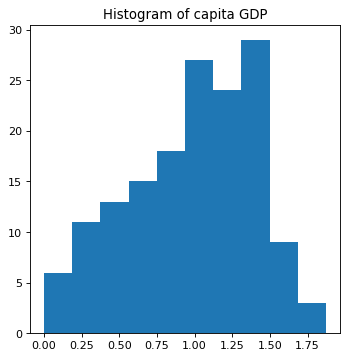

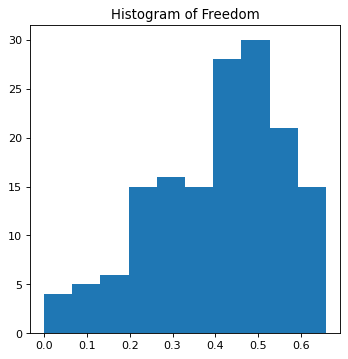

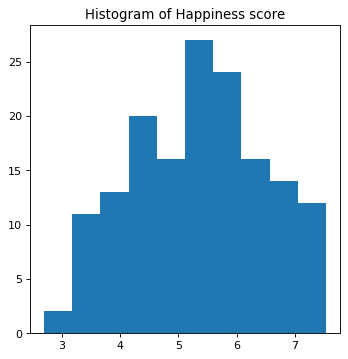

In [95]:
def plotHistogram(x, variableName):
    plt.figure(figsize = (5, 5), dpi = 80)
    n, bins, patches = plt.hist(x, 10)
    plt.title('Histogram of ' + variableName)
    plt.show()

plotHistogram([inp[0] for inp in inputs], 'capita GDP')
plotHistogram([inp[1] for inp in inputs], 'Freedom')
plotHistogram(outputs, 'Happiness score')

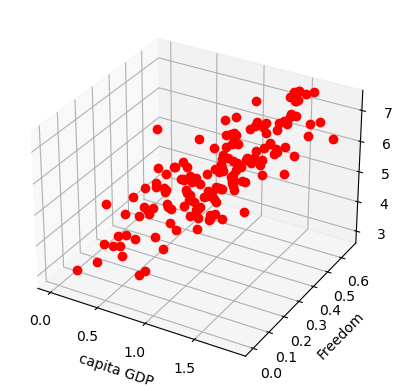

In [96]:
def plotData(inputs, outputs):
    ax = plt.axes(projection = '3d')
    ax.plot3D([inp[0] for inp in inputs], [inp[1] for inp in inputs], outputs, 'ro')
    ax.set_xlabel('capita GDP')
    ax.set_ylabel('Freedom')
    plt.show()
plotData(inputs, outputs)

In [97]:
def splitData(inputs, outputs):
    indexes = [i for i in range(len(inputs))]
    trainIndexes = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    validationIndexes = [i for i in indexes if i not in trainIndexes] 

    trainInputs = [inputs[i] for i in trainIndexes]
    trainOuputs = [outputs[i] for i in trainIndexes]

    validationInputs = [inputs[i] for i in validationIndexes]
    validationOuputs = [outputs[i] for i in validationIndexes]

    return [[trainInputs, trainOuputs], [validationInputs, validationOuputs]]

[train, validation] = splitData(inputs, outputs)

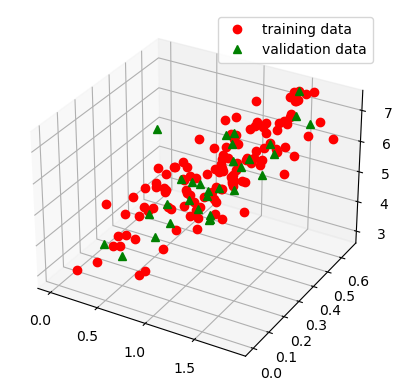

In [98]:
def plotSplitData(train, validation):
    ax = plt.axes(projection = '3d')
    ax.plot3D([tr[0] for tr in train[0]], [tr[1] for tr in train[0]], train[1], 'ro', label = 'training data')
    ax.plot3D([val[0] for val in validation[0]], [val[1] for val in validation[0]], validation[1], 'g^', label = 'validation data')
    plt.legend()
    plt.show()

plotSplitData(train, validation)